In [1]:
### Importing required libraries 
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.sql.functions import col, explode, array, lit
import pandas as pd

from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import date_format

#For visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import re 

### Importing spark nlp libraries
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, size, to_date
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes 
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

In [2]:
!/mnt/miniconda/bin/pip install spark-nlp==4.2.1 --force
!/mnt/miniconda/bin/pip install sparknlp

     |████████████████████████████████| 643 kB 33.4 MB/s eta 0:00:01
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 4.4.0
    Uninstalling spark-nlp-4.4.0:
      Successfully uninstalled spark-nlp-4.4.0


In [3]:
spark = SparkSession.builder \
        .appName("SparkNLP") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.1") \
    .master('yarn') \
    .getOrCreate()

Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-896ecafd-23b8-4488-b0af-aee493498f0d;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	foun

In [5]:
spark

In [6]:
### Importing the data 
df_com = spark.read.parquet("s3a://final-pro-buck0/worldnews/preprocessed_comments/")

In [7]:
### Viewing the specs
print(df_com.count())
df_com.printSchema()

16171595
root
 |-- id: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- date_clean: date (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- finished_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [8]:
count_con = df_com.groupby("controversiality").count().show(10, truncate = False)

+----------------+--------+
|controversiality|count   |
+----------------+--------+
|1               |854748  |
|0               |15316847|
+----------------+--------+



In [9]:
#TF-IDF Vectorization
tf = CountVectorizer(inputCol='finished_clean',
                     outputCol='tf_features')
#Fitting and transforming to get term-frequencies
tf_model = tf.fit(df_com)
tf_result = tf_model.transform(df_com)

In [10]:
#Inverse Document Frequency 
idf = IDF(inputCol='tf_features', 
          outputCol='tf_idf_features')

#Fitting and transforming to get inverse document frequency
idf_model = idf.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

23/04/14 00:03:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/04/14 00:04:08 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [11]:
#Check intermediate results
tfidf_result.show()

23/04/14 00:04:10 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


+-------+------------+----------+--------------------+----------------+--------------------+--------------------+--------------------+
|     id|created_date|date_clean|                body|controversiality|      finished_clean|         tf_features|     tf_idf_features|
+-------+------------+----------+--------------------+----------------+--------------------+--------------------+--------------------+
|i0z8a7j|  03-17-2022|2022-03-17|Maybe you can ask...|               0|[connect, grid, t...|(262144,[14,61,23...|(262144,[14,61,23...|
|i0z8ait|  03-17-2022|2022-03-17|Hopefully they’ll...|               0|[theyll, hide, so...|(262144,[12,578,6...|(262144,[12,578,6...|
|i0z8al9|  03-17-2022|2022-03-17|Literally none of...|               1|[literally, relia...|(262144,[85,110,3...|(262144,[85,110,3...|
|i0z8aoj|  03-17-2022|2022-03-17|Or the bog of ete...|               0|[bog, eternal, st...|(262144,[5316,588...|(262144,[5316,588...|
|i0z8apf|  03-17-2022|2022-03-17|You tell us? Your...| 

In [12]:
model_df = tfidf_result.select("controversiality","tf_idf_features")
model_df.show(10, truncate = False)

23/04/14 00:04:14 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|controversiality|tf_idf_features                                                                                                                                                                                                                                                                                                                                                                                                                            |
+----------------+----------------------------------------------------------------------------------------

In [49]:
#split the data 
training_df,test_df=model_df.randomSplit([0.75,0.25])
training_df.show(4,truncate = False )

23/04/14 01:58:00 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


+----------------+---------------+
|controversiality|tf_idf_features|
+----------------+---------------+
|0               |(262144,[],[]) |
|0               |(262144,[],[]) |
|0               |(262144,[],[]) |
|0               |(262144,[],[]) |
+----------------+---------------+
only showing top 4 rows



### Logistic Regression Model 

In [15]:
#Apply the logistic regression model
log_reg=LogisticRegression(featuresCol = "tf_idf_features",labelCol='controversiality',maxIter=5)
trmodel = log_reg.fit(training_df)

23/04/14 00:04:27 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:10 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:11 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:15 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:16 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/14 00:05:16 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/04/14 00:05:16 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:20 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:20 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:24 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:24 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:05:

In [16]:
predictions = trmodel.transform(test_df)
predictions.select('controversiality','prediction','probability').toPandas().head(5)

/usr/lib/spark/python/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
23/04/14 00:05:40 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


,controversiality,prediction,probability
0,0,0.0,"[0.9483688132471412, 0.05163118675285884]"
1,0,0.0,"[0.9483688132471412, 0.05163118675285884]"
2,0,0.0,"[0.9483688132471412, 0.05163118675285884]"
3,0,0.0,"[0.9483688132471412, 0.05163118675285884]"
4,0,0.0,"[0.9483688132471412, 0.05163118675285884]"


Confusion Matrix

In [17]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

23/04/14 00:07:19 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
23/04/14 00:08:12 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


Confusion matrix, without normalization
[[   1114  212348]
 [   8721 3822318]]


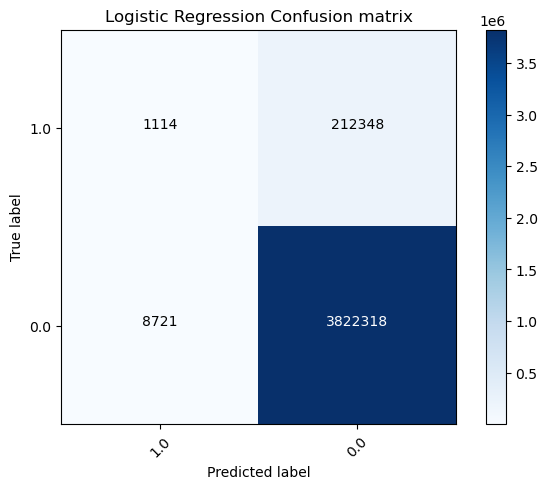

In [18]:
y_true = predictions.select("controversiality")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Logistic Regression Confusion matrix')
plt.savefig("LogisticM-ConfusionMatrix.png")
plt.show()

Accuracy

In [19]:
### Getting the accuracy and printing it 
evaluator_cv = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "accuracy")
accuracy_lr = evaluator_cv.evaluate(predictions)
evaluator_cv_pre = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "precisionByLabel")
precision_lr = evaluator_cv_pre.evaluate(predictions)
evaluator_cv_rec = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "recallByLabel")
recall_lr = evaluator_cv_rec.evaluate(predictions)
evaluator_cv_f1 = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "f1")
f1_lr = evaluator_cv_f1.evaluate(predictions)

print("Accuracy = %g" % accuracy_lr)
print("Test Error = %g" % (1.0 - accuracy_lr))
print("Precision = %g" % precision_lr)
print("Recall = %g" % recall_lr)
print("F1 Score = %g" % f1_lr)

metrics_lr_dict = {"Accuracy" : [accuracy_lr],
                   "Precision" : [precision_lr],
                   "Recall" : [recall_lr], 
                   "F1 Score" : [f1_lr]}

metrics_lr_df = pd.DataFrame(metrics_lr_dict)
metrics_lr_df

23/04/14 00:08:53 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/04/14 00:09:31 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/04/14 00:10:08 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/04/14 00:10:45 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


Accuracy = 0.945341
Test Error = 0.0546592
Precision = 0.947369
Recall = 0.997724
F1 Score = 0.921126


,Accuracy,Precision,Recall,F1 Score
0,0.945341,0.947369,0.997724,0.921126


23/04/14 00:11:22 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


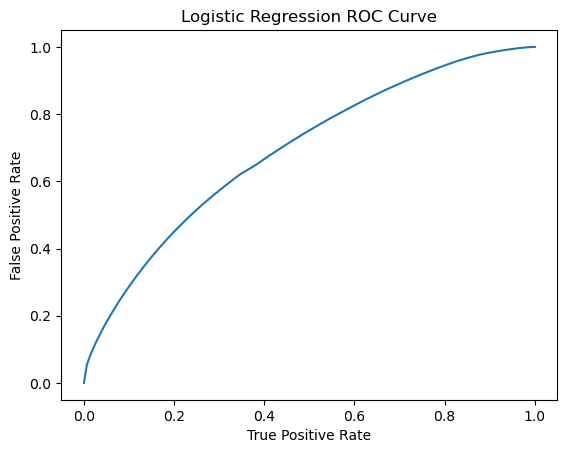

Training set areaUnderROC: 0.6918447135139005


In [20]:
trainingSummary = trmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.savefig("LogisticM-ROC.png")
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Linear SVC Model 

In [21]:
lsvc = LinearSVC(featuresCol = "tf_idf_features",labelCol='controversiality', maxIter=50)
lsvc = lsvc.fit(training_df)

23/04/14 00:12:25 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:07 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:12 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:13 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:16 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:17 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:20 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:21 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:13:27 WARN DAGScheduler: Broadcasting larg

In [22]:
pred = lsvc.transform(test_df)
pred.show(3)

23/04/14 00:19:37 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


+----------------+---------------+--------------------+----------+
|controversiality|tf_idf_features|       rawPrediction|prediction|
+----------------+---------------+--------------------+----------+
|               0| (262144,[],[])|[1.00010398556288...|       0.0|
|               0| (262144,[],[])|[1.00010398556288...|       0.0|
|               0| (262144,[],[])|[1.00010398556288...|       0.0|
+----------------+---------------+--------------------+----------+
only showing top 3 rows



In [23]:
pred.select('controversiality','prediction').toPandas().head(5)

23/04/14 00:19:49 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


,controversiality,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


23/04/14 00:20:30 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
23/04/14 00:21:07 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


Confusion matrix, without normalization
[[    396  213066]
 [   4314 3826725]]


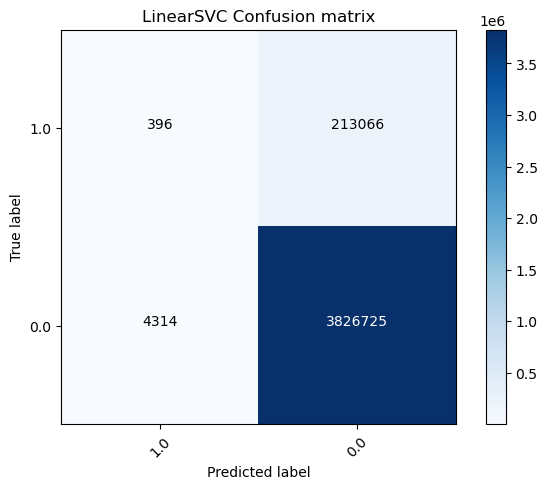

In [24]:
y_true = pred.select("controversiality")
y_true = y_true.toPandas()

y_pred = pred.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='LinearSVC Confusion matrix')
plt.savefig("LinearSVC-ConfusionMatrix.png")
plt.show()

In [25]:
evaluator_cv_svc = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "accuracy")
accuracy_svc = evaluator_cv_svc.evaluate(pred)
evaluator_svc_pre = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "precisionByLabel")
precision_svc = evaluator_svc_pre.evaluate(pred)
evaluator_svc_rec = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "recallByLabel")
recall_svc = evaluator_svc_rec.evaluate(pred)
evaluator_svc_f1 = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "f1")
f1_svc = evaluator_svc_f1.evaluate(pred)


print("Accuracy = %g" % accuracy_svc)
print("Test Error = %g" % (1.0 - accuracy_svc))
print("Precision = %g" % precision_svc)
print("Recall = %g" % recall_svc)
print("F1 Score = %g" % f1_svc)

metrics_svc_dict = {"Accuracy" : [accuracy_svc],
                   "Precision" : [precision_svc],
                   "Recall" : [recall_svc], 
                   "F1 Score" : [f1_svc]}

metrics_svc_df = pd.DataFrame(metrics_svc_dict)
metrics_svc_df

23/04/14 00:21:50 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/04/14 00:22:26 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/04/14 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/04/14 00:23:39 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


Accuracy = 0.946253
Test Error = 0.0537471
Precision = 0.947258
Recall = 0.998874
F1 Score = 0.921252


,Accuracy,Precision,Recall,F1 Score
0,0.946253,0.947258,0.998874,0.921252


In [26]:
class CurveMetrics(BinaryClassificationMetrics):
    """"
    This class gets the roc curve for models which lack a model summary.
    """
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)
    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

23/04/14 00:24:14 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/04/14 00:24:26 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


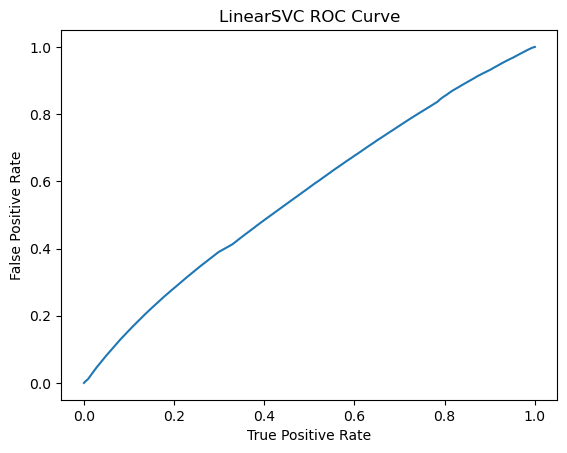

In [27]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
# model = estimator.fit(train)
# predictions = model.transform(test)

# Returns as a list (false positive rate, true positive rate)
preds = pred.select('controversiality','rawPrediction').rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['controversiality'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('LinearSVC ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
#plt.savefig("LinearSVC-ROC.png")
plt.show()

### Naïve Bayes classifier

In [29]:
lsvc = LinearSVC(featuresCol = "tf_idf_features",labelCol='controversiality', maxIter=50)
lsvc = lsvc.fit(training_df)

23/04/14 00:25:20 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:01 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:02 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:05 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:05 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:09 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:11 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:12 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:15 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:15 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:26:18 WARN DAGScheduler: Broadcasting larg

In [30]:
nb = NaiveBayes(featuresCol = "tf_idf_features",labelCol='controversiality',modelType="multinomial")
nbmodel = nb.fit(training_df)

23/04/14 00:31:31 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/14 00:32:09 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


In [31]:
predictions_df = nbmodel.transform(test_df)
predictions_df.show(5, True)

23/04/14 00:32:10 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


+----------------+---------------+--------------------+--------------------+----------+
|controversiality|tf_idf_features|       rawPrediction|         probability|prediction|
+----------------+---------------+--------------------+--------------------+----------+
|               0| (262144,[],[])|[-0.0543300144990...|[0.94711949175631...|       0.0|
|               0| (262144,[],[])|[-0.0543300144990...|[0.94711949175631...|       0.0|
|               0| (262144,[],[])|[-0.0543300144990...|[0.94711949175631...|       0.0|
|               0| (262144,[],[])|[-0.0543300144990...|[0.94711949175631...|       0.0|
|               0| (262144,[],[])|[-0.0543300144990...|[0.94711949175631...|       0.0|
+----------------+---------------+--------------------+--------------------+----------+
only showing top 5 rows



23/04/14 00:32:21 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
23/04/14 00:32:53 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


Confusion matrix, without normalization
[[  91155  122307]
 [ 894720 2936319]]


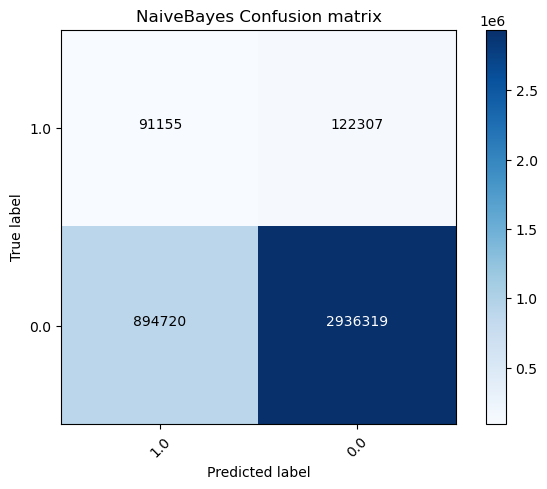

In [32]:
y_true = predictions_df.select("controversiality")
y_true = y_true.toPandas()

y_pred = predictions_df.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='NaiveBayes Confusion matrix')
plt.savefig("NaiveBayes-ConfusionMatrix.png")
plt.show()

In [33]:
## Evaluating the metrics 
evaluator_nb = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "accuracy")
accuracy_nb = evaluator_nb.evaluate(predictions_df)
evaluator_nb_pre = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "precisionByLabel")
precision_nb = evaluator_nb_pre.evaluate(predictions_df)
evaluator_nb_rec = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "recallByLabel")
recall_nb = evaluator_nb_rec.evaluate(predictions_df)
evaluator_nb_f1 = MulticlassClassificationEvaluator(labelCol = "controversiality", predictionCol = "prediction", metricName = "f1")
f1_nb = evaluator_nb_f1.evaluate(predictions_df)

print("Accuracy = %g" % accuracy_nb)
print("Test Error = %g" % (1.0 - accuracy_nb))
print("Precision = %g" % precision_nb)
print("Recall = %g" % recall_nb)
print("F1 Score = %g" % f1_nb)

metrics_nb_dict = {"Accuracy" : [accuracy_nb],
                   "Precision" : [precision_nb],
                   "Recall" : [recall_nb], 
                   "F1 Score" : [f1_nb]}

metrics_nb_df = pd.DataFrame(metrics_nb_dict)
metrics_nb_df

23/04/14 00:33:30 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
23/04/14 00:34:04 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
23/04/14 00:34:36 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
23/04/14 00:35:08 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


Accuracy = 0.748541
Test Error = 0.251459
Precision = 0.960012
Recall = 0.766455
F1 Score = 0.815419


,Accuracy,Precision,Recall,F1 Score
0,0.748541,0.960012,0.766455,0.815419


23/04/14 00:35:41 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
23/04/14 00:35:51 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


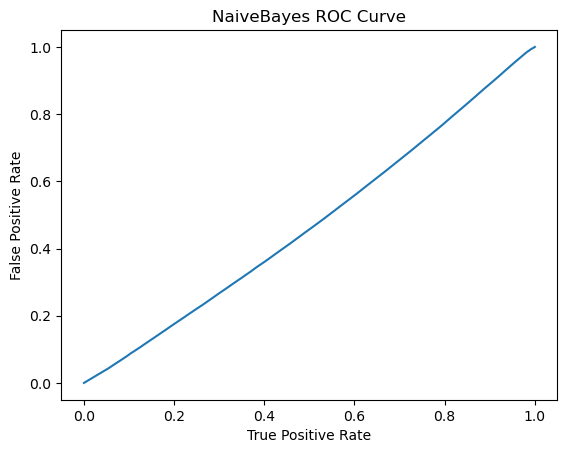

In [34]:
preds = predictions_df.select('controversiality','rawPrediction').rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['controversiality'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('NaiveBayes ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
plt.savefig("NaiveBayes-ROC.png")
plt.show()

23/04/14 02:13:31 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/04/14 02:13:34 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/04/14 02:13:51 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
23/04/14 02:13:54 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


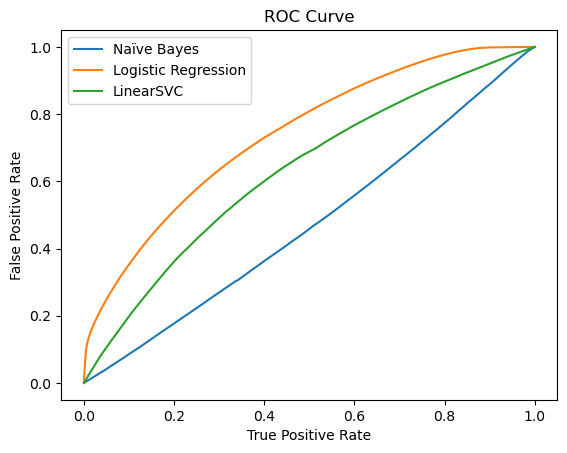

In [56]:
## integrate all roc 
## nb 
preds = predictions_df.select('controversiality','rawPrediction').rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['controversiality'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val,label="Naïve Bayes")

## LogisticM
trainingSummary = trmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'],label="Logistic Regression")

## LinearSVC
preds = pred.select('controversiality','rawPrediction').rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['controversiality'])))
points_svc = CurveMetrics(preds).get_curve('roc')
x_val_svc = [x[0] for x in points_svc]
y_val_svc = [x[1] for x in points_svc]
plt.plot(x_val_svc, y_val_svc,label="LinearSVC")
#add legend
plt.legend()
#plt.savefig("ALL-ROC.png")
plt.show()

In [41]:
metrics = [metrics_lr_df, metrics_nb_df, metrics_svc_df]

metrics_df = pd.concat(metrics)
metrics_df.index = ["Logistic Regression", "Mulitnomial Naive Bayes", "LinearSVC"]
metrics_df = metrics_df.round(2)
### Saving to csv 
metrics_df.to_csv("Controversiality_metrics.csv")

## Oversampling & Undersampling

In [35]:
df_com.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- date_clean: date (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- finished_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [36]:
df_com.groupby("controversiality").count().show(10, truncate = False)

+----------------+--------+
|controversiality|count   |
+----------------+--------+
|1               |854748  |
|0               |15316847|
+----------------+--------+



In [37]:
major_df = df_com.filter(col("controversiality") == 0)
minor_df = df_com.filter(col("controversiality") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
a = range(ratio)

ratio: 17


In [38]:
### Oversampling
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.groupby("controversiality").count().show(10, truncate = False)

+----------------+--------+
|controversiality|count   |
+----------------+--------+
|1               |14530716|
|0               |15316847|
+----------------+--------+



In [39]:
### Undersampling
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(minor_df)
combined_df_2.groupby("controversiality").count().show(10, truncate = False)

+----------------+------+
|controversiality|count |
+----------------+------+
|1               |854748|
|0               |901719|
+----------------+------+



#### Oversampling

In [40]:
combined_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- date_clean: date (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- finished_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [41]:
#TF-IDF Vectorization
tf = CountVectorizer(inputCol='finished_clean',
                     outputCol='tf_features')
#Fitting and transforming to get term-frequencies
tf_model = tf.fit(combined_df)
tf_result = tf_model.transform(combined_df)

#Inverse Document Frequency 

idf = IDF(inputCol='tf_features', 
          outputCol='tf_idf_features')

#Fitting and transforming to get inverse document frequency
idf_model = idf.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

23/04/14 00:37:31 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
23/04/14 00:38:22 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


In [42]:
model_df = tfidf_result.select("controversiality","tf_idf_features")
#model_df.show(10, truncate = False)

#split the data 
training_df,test_df=model_df.randomSplit([0.75,0.25])
training_df.show(4,truncate = False )

23/04/14 00:38:23 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


+----------------+---------------+
|controversiality|tf_idf_features|
+----------------+---------------+
|0               |(262144,[],[]) |
|0               |(262144,[],[]) |
|0               |(262144,[],[]) |
|0               |(262144,[],[]) |
+----------------+---------------+
only showing top 4 rows



In [43]:
#Apply the logistic regression model
log_reg=LogisticRegression(featuresCol = "tf_idf_features",labelCol='controversiality',maxIter=5)
trmodel = log_reg.fit(training_df)
predictions = trmodel.transform(test_df)
predictions.select('controversiality','prediction','probability').toPandas().head(5)
accuracy = predictions.filter(predictions.controversiality == predictions.prediction).count() / float(predictions.count())
print("LogisticRegression Accuracy : ",accuracy)

23/04/14 00:38:35 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:37 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:38 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:44 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:45 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:50 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:50 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:56 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:39:56 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:40:02 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:40:03 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:40:08 WARN DAGScheduler: Broadcasting larg

LogisticRegression Accuracy :  0.6511206030029495


In [44]:
#Apply the LinearSVC regression model
lsvc = LinearSVC(featuresCol = "tf_idf_features",labelCol='controversiality', maxIter=50)
lsvc = lsvc.fit(training_df)
pred = lsvc.transform(test_df)
accuracy_LinearSVC = pred.filter(pred.controversiality == pred.prediction).count() / float(pred.count())
print("LinearSVC Accuracy : ",accuracy_LinearSVC)

23/04/14 00:44:14 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:09 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:10 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:14 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:15 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:19 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:20 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:24 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:25 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:29 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:30 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:45:34 WARN DAGScheduler: Broadcasting larg

LinearSVC Accuracy :  0.6452849305835029


In [45]:
nb = NaiveBayes(featuresCol = "tf_idf_features",labelCol='controversiality',modelType="multinomial")
nbmodel = nb.fit(training_df)
predictions_df = nbmodel.transform(test_df)
accuracy_NaiveBayes = predictions_df.filter(predictions_df.controversiality == predictions_df.prediction).count() / float(predictions_df.count())
print("NaiveBayes Accuracy : ",accuracy_NaiveBayes)

23/04/14 00:55:12 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:56:05 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/04/14 00:56:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
23/04/14 00:56:56 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


NaiveBayes Accuracy :  0.6416140243819062


#### Undersampling

In [46]:
#TF-IDF Vectorization
tf = CountVectorizer(inputCol='finished_clean',
                     outputCol='tf_features')
#Fitting and transforming to get term-frequencies
tf_model = tf.fit(combined_df_2)
tf_result = tf_model.transform(combined_df_2)

#Inverse Document Frequency 

idf = IDF(inputCol='tf_features', 
          outputCol='tf_idf_features')

#Fitting and transforming to get inverse document frequency
idf_model = idf.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

23/04/14 00:57:59 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
23/04/14 00:58:16 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


In [47]:
model_df = tfidf_result.select("controversiality","tf_idf_features")
#model_df.show(10, truncate = False)

#split the data 
training_df,test_df=model_df.randomSplit([0.75,0.25])
#training_df.show(4,truncate = False )

In [48]:
#Apply the logistic regression model
log_reg=LogisticRegression(featuresCol = "tf_idf_features",labelCol='controversiality',maxIter=5)
trmodel = log_reg.fit(training_df)
predictions = trmodel.transform(test_df)
predictions.select('controversiality','prediction','probability').toPandas().head(5)
accuracy = predictions.filter(predictions.controversiality == predictions.prediction).count() / float(predictions.count())
print("LogisticRegression Accuracy : ",accuracy)

#Apply the LinearSVC regression model
lsvc = LinearSVC(featuresCol = "tf_idf_features",labelCol='controversiality', maxIter=50)
lsvc = lsvc.fit(training_df)
pred = lsvc.transform(test_df)
accuracy_LinearSVC = pred.filter(pred.controversiality == pred.prediction).count() / float(pred.count())
print("LinearSVC Accuracy : ",accuracy_LinearSVC)

nb = NaiveBayes(featuresCol = "tf_idf_features",labelCol='controversiality',modelType="multinomial")
nbmodel = nb.fit(training_df)
predictions_df = nbmodel.transform(test_df)
accuracy_NaiveBayes = predictions_df.filter(predictions_df.controversiality == predictions_df.prediction).count() / float(predictions_df.count())
print("NaiveBayes Accuracy : ",accuracy_NaiveBayes)

23/04/14 00:58:17 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:33 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:34 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:35 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:36 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:38 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:39 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:41 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:41 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:43 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:44 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 00:58:46 WARN DAGScheduler: Broadcasting larg

LogisticRegression Accuracy :  0.6039280651173163


23/04/14 00:59:46 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:03 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:03 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:05 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:06 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:08 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:08 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:10 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:11 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:12 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:13 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/04/14 01:00:15 WARN DAGScheduler: Broadcasting larg

LinearSVC Accuracy :  0.5948941069921015


23/04/14 01:04:55 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
23/04/14 01:05:11 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
23/04/14 01:05:12 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
23/04/14 01:05:28 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


NaiveBayes Accuracy :  0.599579477213718


In [ ]:
spark.stop()